In [65]:
from typing import TypedDict
from dotenv import load_dotenv
from langgraph.graph import StateGraph
from typing import Literal
from IPython.core.display import Image
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.constants import START, END
from langchain_community.tools import TavilySearchResults
from langchain_openai import ChatOpenAI

from agent import graph

load_dotenv()

True

In [66]:

class Car_Telemetry():
    tyre_laps: int
    tyre_type: Literal["Soft","Medium","Hard"]
    fuel_remaining_kg: float
    brake_temp_FL: int
    engine_mode: str
    drs_available: bool
    laps_remaining: int

class PrincipalState(TypedDict):
    current_lap: int
    driver_feedback: str
    telemetry: Car_Telemetry
    strategy_recommendation: str
    engineering_report: str
    final_decision: str

class RaceStratState(TypedDict):
    telemetry: Car_Telemetry
    tyre_wear: str
    strategy_recommendation: str

class EngineerStateState(TypedDict):
    driver_feedback: str
    telemetry: Car_Telemetry

    telemetry_feedback: str
    technical_feedback: str
    engineering_report: str


class RaceStratOutput(TypedDict):
    strategy_recommendation: str

class EngineerOutput(TypedDict):
    engineering_report: str


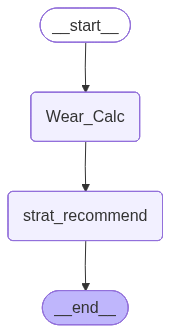

In [67]:
#Defining sub graph 1 - Race Strategist

def check_tyreWear(state):
    tyre = state["telemetry"]["tyre_type"]
    laps = state["telemetry"]["tyre_laps"]
    wear_rate = 0
    if tyre == "Soft":
        wear_rate = 5.85
    elif tyre == "Medium":
        wear_rate = 4.16
    else:
        wear_rate = 3.25
    return {"tyre_wear": f"The tyre wear is close to {wear_rate*laps}%"}

def strat_recommend(state):
    llm_strat = ChatOpenAI(model="gpt-5-nano-2025-08-07")
    messages=[
        SystemMessage("You are a F1 race strategist for a F1 team and use maximum of 20-30 words"),
        HumanMessage(f"{state['telemetry']} using this and {state['tyre_wear']} suggest a probable strategy for the race assuming this if tyre == 'Soft': wear_rate = 5.85 elif tyre == 'Medium': wear_rate = 4.16 elif tyre == 'Hard': wear_rate = 3.25 ")
    ]
    res = llm_strat.invoke(messages)
    return {"strategy_recommendation" : res.content }

RS_builder = StateGraph(RaceStratState, output_schema=RaceStratOutput)
RS_builder.add_node("Wear_Calc",check_tyreWear)
RS_builder.add_node("strat_recommend",strat_recommend)
RS_builder.add_edge(START,"Wear_Calc")
RS_builder.add_edge("Wear_Calc","strat_recommend")
RS_builder.add_edge("strat_recommend", END)

RS_graph  = RS_builder.compile()
display(Image(RS_graph.get_graph().draw_mermaid_png()))

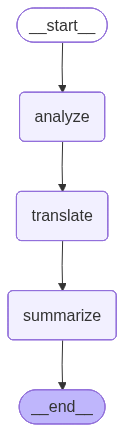

In [68]:
#Defining sub graph 2 - Race Engineer

llm_race = ChatOpenAI(model="gpt-5-nano-2025-08-07", temperature=0)
messages = [SystemMessage("You are a F1 race Engineer for a driver and use maximum of 20-30 words")]

def analyze(state):
    # CORRECT: Concatenate lists, not a message object and a list
    temp_msg = messages + [HumanMessage(f"Use the telemetry data {state['telemetry']} and suggest if there are any issues in the car")]
    res = llm_race.invoke(temp_msg)
    return { "telemetry_feedback" : res.content }

def translate(state):
    # CORRECT: Concatenate lists
    temp_msg = messages + [HumanMessage(f"Translate the driver's feedback into more technical terms to an extent, {state['driver_feedback']}")]
    res = llm_race.invoke(temp_msg)
    return { "technical_feedback" : res.content }

def summarize(state):
    # CORRECT: Concatenate lists
    temp_msg = messages + [HumanMessage(f"Using the following give me a summary to use {state['telemetry_feedback']} and {state['technical_feedback']}")]
    res = llm_race.invoke(temp_msg)
    return { "engineering_report" : res.content }

RE_builder = StateGraph(EngineerStateState, output_schema=EngineerOutput)
RE_builder.add_node("analyze",analyze)
RE_builder.add_node("translate",translate)
RE_builder.add_node("summarize",summarize)
RE_builder.add_edge(START,"analyze")
RE_builder.add_edge("analyze","translate")
RE_builder.add_edge("translate","summarize")
RE_builder.add_edge("summarize", END)

RE_graph  = RE_builder.compile()
display(Image(RE_graph.get_graph().draw_mermaid_png()))

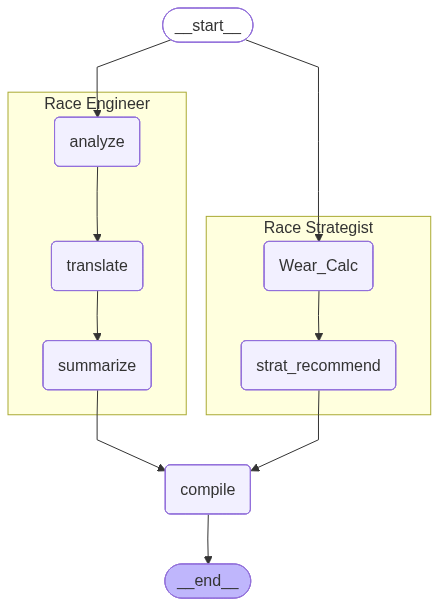

In [69]:
def compile(state):
    llm = ChatOpenAI(model="gpt-4o")
    messages = [SystemMessage("This is a group of messages related to F1 and use maximum of 20-30 words"),HumanMessage(f"Compile these messages and get to a final decision {state['strategy_recommendation']} and {state['engineering_report']}")]
    res = llm.invoke(messages)

    return {"final_decision":res.content}


builder = StateGraph(PrincipalState)


builder.add_node("Race Strategist",RS_builder.compile())
builder.add_node("Race Engineer",RE_builder.compile())
builder.add_node("compile",compile)


builder.add_edge(START,"Race Engineer")
builder.add_edge(START,"Race Strategist")
builder.add_edge("Race Engineer","compile")
builder.add_edge("Race Strategist","compile")
builder.add_edge("compile",END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [70]:
sample_input = {
    "current_lap": 16,
    "driver_feedback": "The car feels a bit loose on corner exit, rear tires might be overheating.",
    "telemetry": {
        "tyre_laps": 15,
        "tyre_type": "Medium",
        "fuel_remaining_kg": 62.5,
        "brake_temp_FL": 920,
        "engine_mode": "Overtake",
        "drs_available": True,
        "laps_remaining": 41
    }
}


result=graph.invoke(sample_input)

In [71]:
for r in result:
    print(f"{r} : {result[r]}")

current_lap : 16
driver_feedback : The car feels a bit loose on corner exit, rear tires might be overheating.
telemetry : {'tyre_laps': 15, 'tyre_type': 'Medium', 'fuel_remaining_kg': 62.5, 'brake_temp_FL': 920, 'engine_mode': 'Overtake', 'drs_available': True, 'laps_remaining': 41}
strategy_recommendation : Two-stop plan: pit now to Hard for ~22–25 laps, then Soft for final 12–15 laps; DRS on; fuel 62.5 kg should cover pace.
engineering_report : Front-left brake 920°C—risk fade; adjust brake balance/cooling. Tyres 15 laps; monitor wear. Fuel 62.5 kg. DRS available; plan safe push. Exit: rear temps rising; check rear pressures and rear-wing settings.
final_decision : Pit now for Hard tires, run 22-25 laps, then switch to Softs for the final 12-15 laps. Monitor front-left brake at 920°C and adjust brake balance/cooling. DRS is on; pace covered with 62.5 kg fuel. Check rear tire pressures and rear-wing settings as rear temps rise.
